<a href="https://colab.research.google.com/github/IA2021UR/trabajo-ia-en-la-comunidad-de-la-rioja-equipo-6/blob/main/Prueba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías

In [1]:
!pip install fastai --upgrade

     |████████████████████████████████| 204kB 11.6MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *


from pathlib import Path
import random

# Dataset

In [3]:
!wget https://www.dropbox.com/s/7s7ck90yhoj15r3/dataset.zip?dl=0 -O dataset.zip

--2021-05-16 12:16:44--  https://www.dropbox.com/s/7s7ck90yhoj15r3/dataset.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7s7ck90yhoj15r3/dataset.zip [following]
--2021-05-16 12:16:44--  https://www.dropbox.com/s/raw/7s7ck90yhoj15r3/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1ed95bc25bc1e0c0748d9c4e43.dl.dropboxusercontent.com/cd/0/inline/BOngqPOqJP_O-tt-fzeevQybev5vqUJKmzlEa8_VacjJMg1hFcl2sM-ENc-LB1ywSLuVcJReJRtQur-vaYhsrmFjKq2m909LQuGsXGFG6lP4v2CAut9v9F-FXsbnm41m-_2g5LSMQO1BXn1EymJEL2pS/file# [following]
--2021-05-16 12:16:44--  https://uc1ed95bc25bc1e0c0748d9c4e43.dl.dropboxusercontent.com/cd/0/inline/BOngqPOqJP_O-tt-fzeevQybev5vqUJKmzlEa8_VacjJMg1hFcl2sM-ENc-LB1ywSLuVcJReJRtQur-vaYhsr

In [4]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/codes.txt       
   creating: dataset/Images/
   creating: dataset/Images/test/
  inflating: dataset/Images/test/22828930_15.tiff  
  inflating: dataset/Images/test/22828990_15.tiff  
  inflating: dataset/Images/test/22829050_15.tiff  
  inflating: dataset/Images/test/23429020_15.tiff  
  inflating: dataset/Images/test/23429080_15.tiff  
  inflating: dataset/Images/test/23578960_15.tiff  
  inflating: dataset/Images/test/23579005_15.tiff  
  inflating: dataset/Images/test/23729035_15.tiff  
  inflating: dataset/Images/test/23879080_15.tiff  
  inflating: dataset/Images/test/24179065_15.tiff  
   creating: dataset/Images/train/
  inflating: dataset/Images/train/22678915_15.tiff  
  inflating: dataset/Images/train/22678930_15.tiff  
  inflating: dataset/Images/train/22678945_15.tiff  
  inflating: dataset/Images/train/22678960_15.tiff  
  inflating: dataset/Images/train/22678975_15.tiff  
  inflating: dataset/Images/train/2

In [5]:
path=Path('dataset/')

In [6]:
path.ls()

(#3) [Path('dataset/codes.txt'),Path('dataset/Images'),Path('dataset/Labels')]

# Definiciones previas

In [7]:
path_images = path/"Images"
path_labels = path/"Labels"

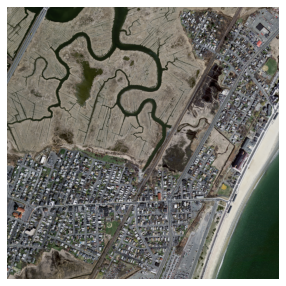

In [8]:
img_1 = path_images/'train/24179080_15.tiff'
img = PILImage.create(img_1)
img.show(figsize=(5, 5))

In [9]:
img.size

(1500, 1500)

In [10]:
test_name = "test"

In [11]:
def get_y_fn (x):
    return Path(str(x).replace("Images","Labels").replace(".tiff",".tif"))

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

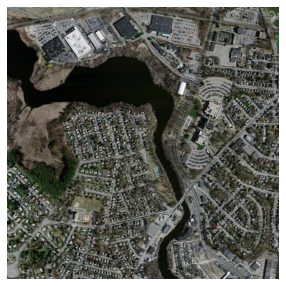

In [13]:
img_f = path_images/'train/22678915_15.tiff'
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [14]:
img.size

(1500, 1500)

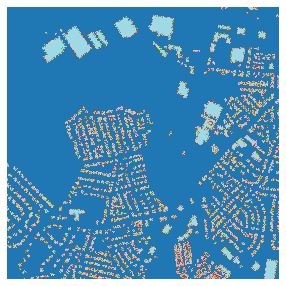

In [15]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

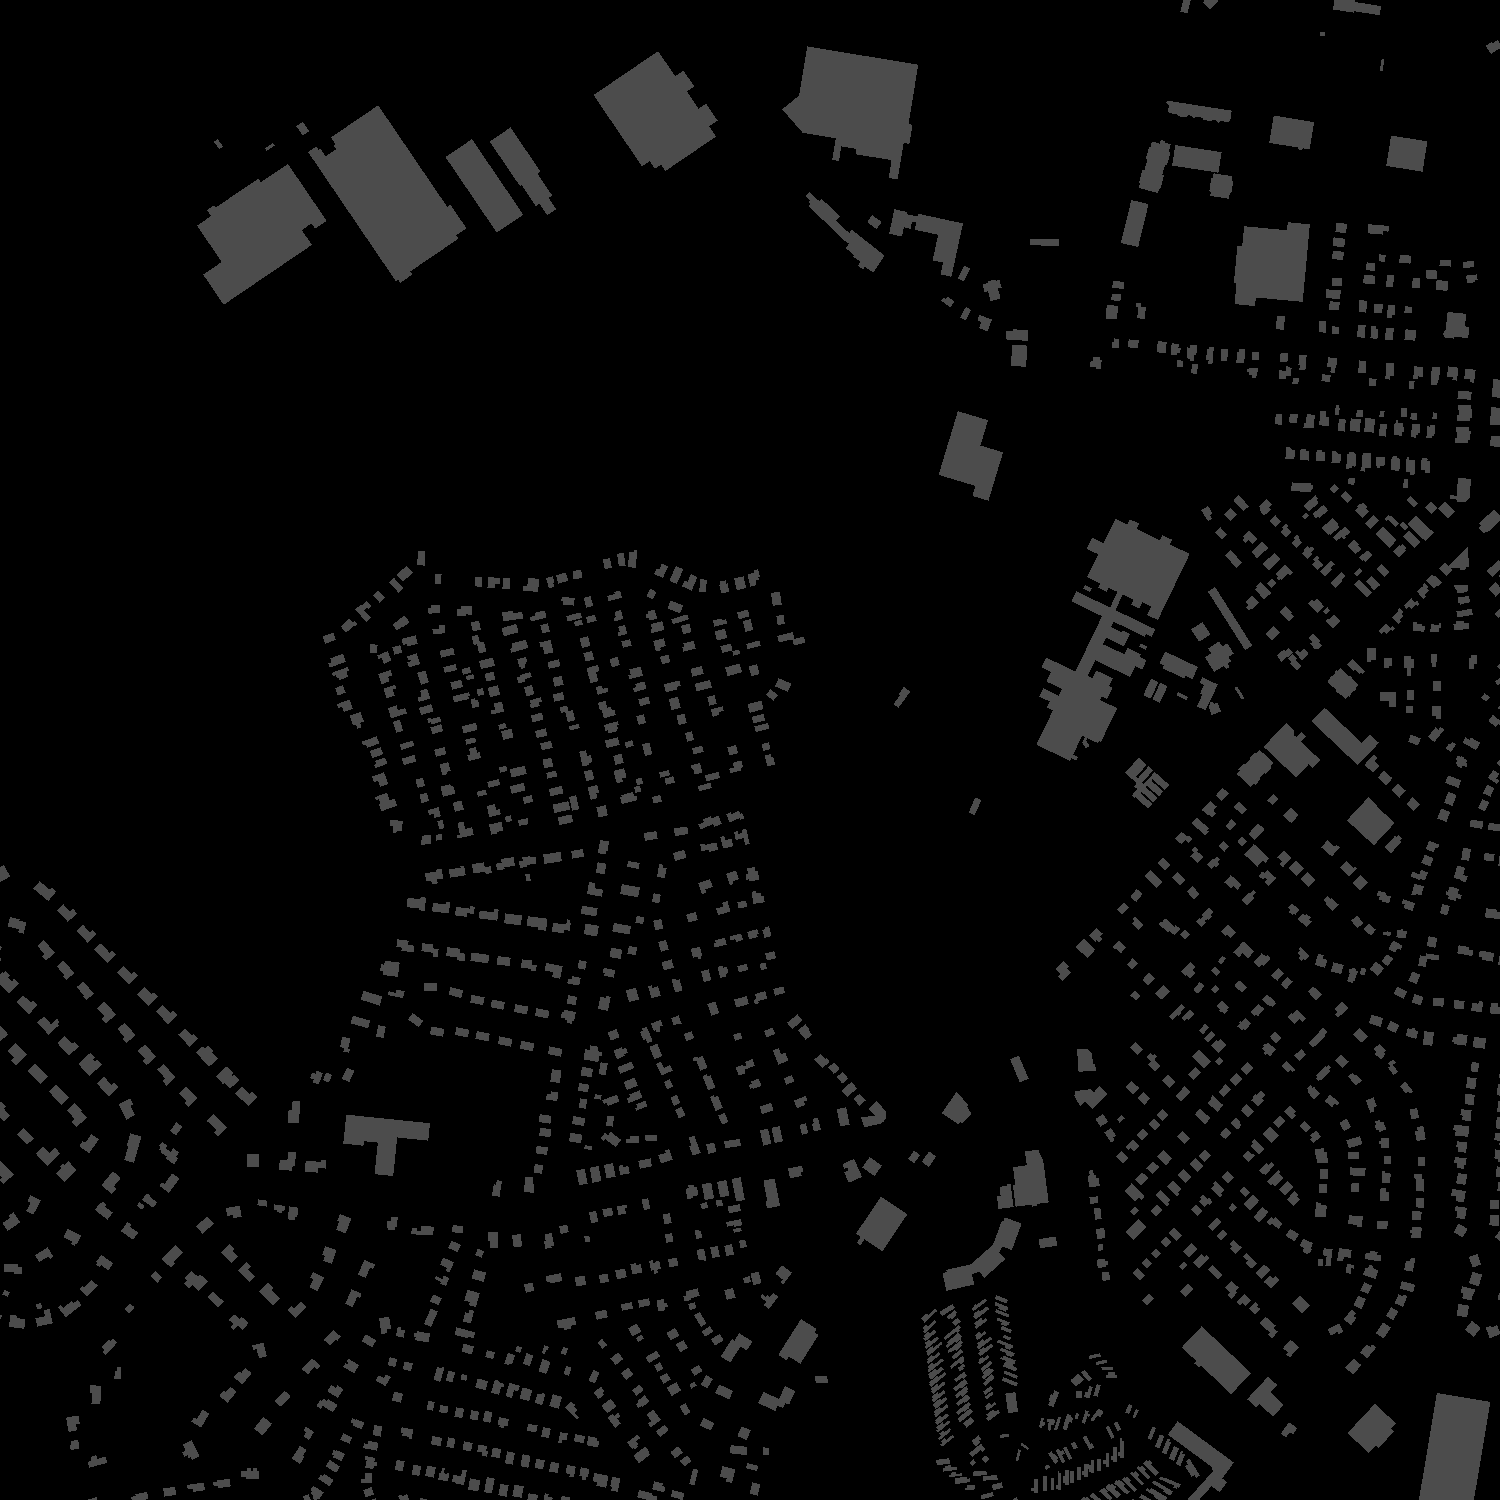

In [16]:
mask

In [17]:
np.unique(mask)

array([ 0, 76], dtype=uint8)

# Partición del dataset

In [18]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

# Data augmentation

In [19]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    HorizontalFlip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    
    def __init__(self, aug): 
        self.aug = aug
        
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

In [20]:
transforms=Compose([HorizontalFlip(p=0.5),
                    Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

In [21]:
transformPipeline=SegmentationAlbumentationsTransform(transforms)

In [22]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        mask[mask!=76]=0
        # Change 76 for 1
        mask[mask==76]=1
        
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

# Dataloader

In [23]:
trainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((1000,1000)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

In [24]:
testDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train','test']),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((1000,1000)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

In [25]:
bs = 1
trainDLS = trainDB.dataloaders(path_images,bs=bs)
testDLS = testDB.dataloaders(path_images,bs=bs)

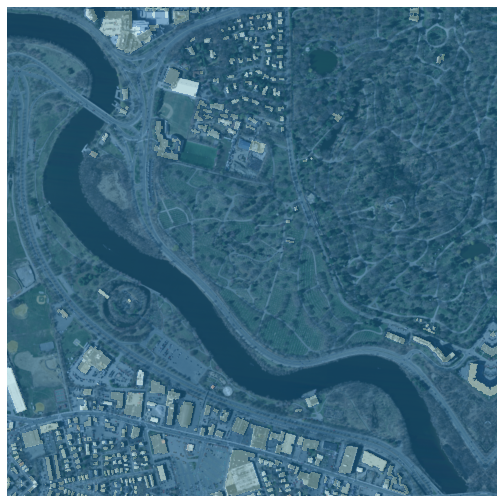

In [26]:
trainDLS.show_batch(vmin=0,vmax=1,figsize=(9, 9))

# Definición de modelo

In [27]:
import torch
torch.cuda.empty_cache()

In [28]:
learn = unet_learner(trainDLS,resnet18,metrics=[Dice(),JaccardCoeff()]).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [29]:
learn.fit_one_cycle(20,slice(1e-5,1e-4))

In [30]:
aux=learn.model
aux=aux.cpu()

In [31]:
import torchvision.transforms as transforms
img = PILImage.create(path_images/'train/22678915_15.tiff')
transformer=transforms.Compose([transforms.Resize((1000,1000)),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                                    [0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])
img=transformer(img).unsqueeze(0)
img=img.cpu()

traced_cell=torch.jit.trace(aux, (img))
traced_cell.save("unet.pth")

/usr/local/lib/python3.7/dist-packages/fastai/vision/models/unet.py:37: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if ssh != up_out.shape[-2:]:
/usr/local/lib/python3.7/dist-packages/fastai/vision/models/unet.py:47: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.orig.shape[-2:] != x.shape[-2:]:


# Evaluando el modelo

In [32]:
learn.dls = testDLS

In [33]:
learn.validate()

(#3) [0.9124782681465149,0.014337640279818162,0.007220583202190836]

# Inferencia

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = torch.jit.load("unet.pth")
model = model.cpu()
model.eval()

RecursiveScriptModule(
  original_name=DynamicUnet
  (layers): RecursiveScriptModule(
    original_name=ModuleList
    (0): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Conv2d)
      (1): RecursiveScriptModule(original_name=BatchNorm2d)
      (2): RecursiveScriptModule(original_name=ReLU)
      (3): RecursiveScriptModule(original_name=MaxPool2d)
      (4): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=BasicBlock
          (conv1): RecursiveScriptModule(original_name=Conv2d)
          (bn1): RecursiveScriptModule(original_name=BatchNorm2d)
          (relu): RecursiveScriptModule(original_name=ReLU)
          (conv2): RecursiveScriptModule(original_name=Conv2d)
          (bn2): RecursiveScriptModule(original_name=BatchNorm2d)
        )
        (1): RecursiveScriptModule(
          original_name=BasicBlock
          (conv1): RecursiveScriptModule(original_name=Conv

In [35]:
import PIL

In [51]:
img = PIL.Image.open('dataset/Images/test/22828930_15.tiff')

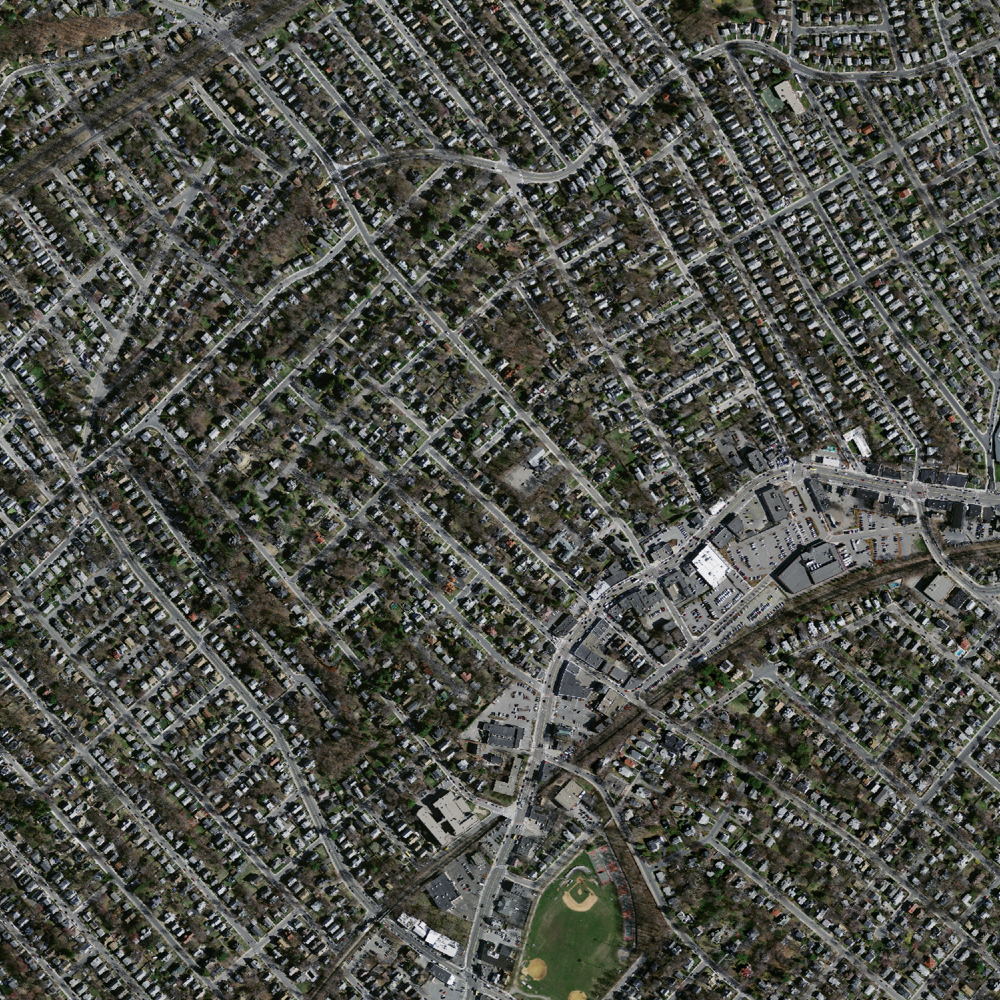

In [61]:
img_muestra = img.copy()
img_muestra.resize((1000,1000))

In [53]:
import torchvision.transforms as transforms
def transform_image(image):
    my_transforms = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])])
    image_aux = image
    return my_transforms(image_aux).unsqueeze(0).to(device)

In [54]:
image = transforms.Resize((1000,1000))(img)
tensor = transform_image(image=image)

In [55]:
model.to(device)
with torch.no_grad():
    outputs = model(tensor)

outputs = torch.argmax(outputs,1)

In [56]:
mask = np.array(outputs.cpu())
mask[mask==1]=76

In [57]:
mask=np.reshape(mask,(1000,1000))

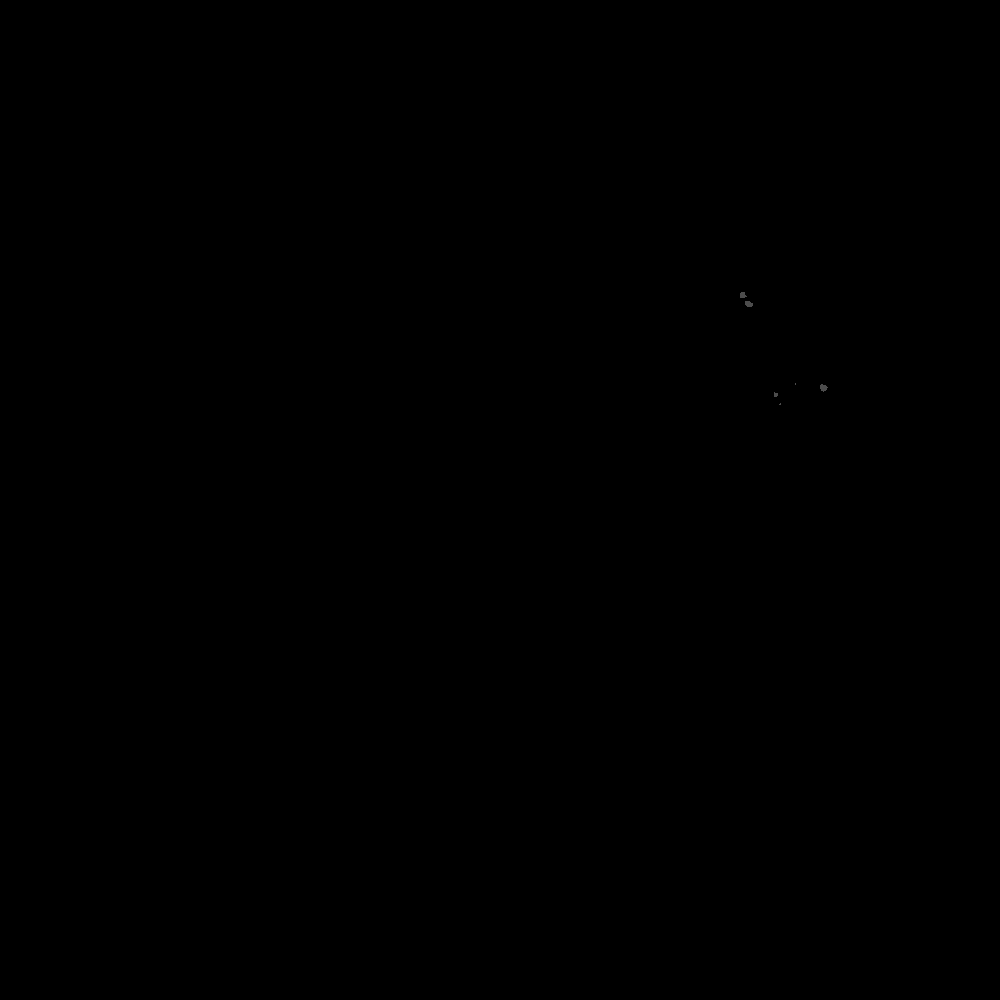

In [58]:
Image.fromarray(mask.astype('uint8'))

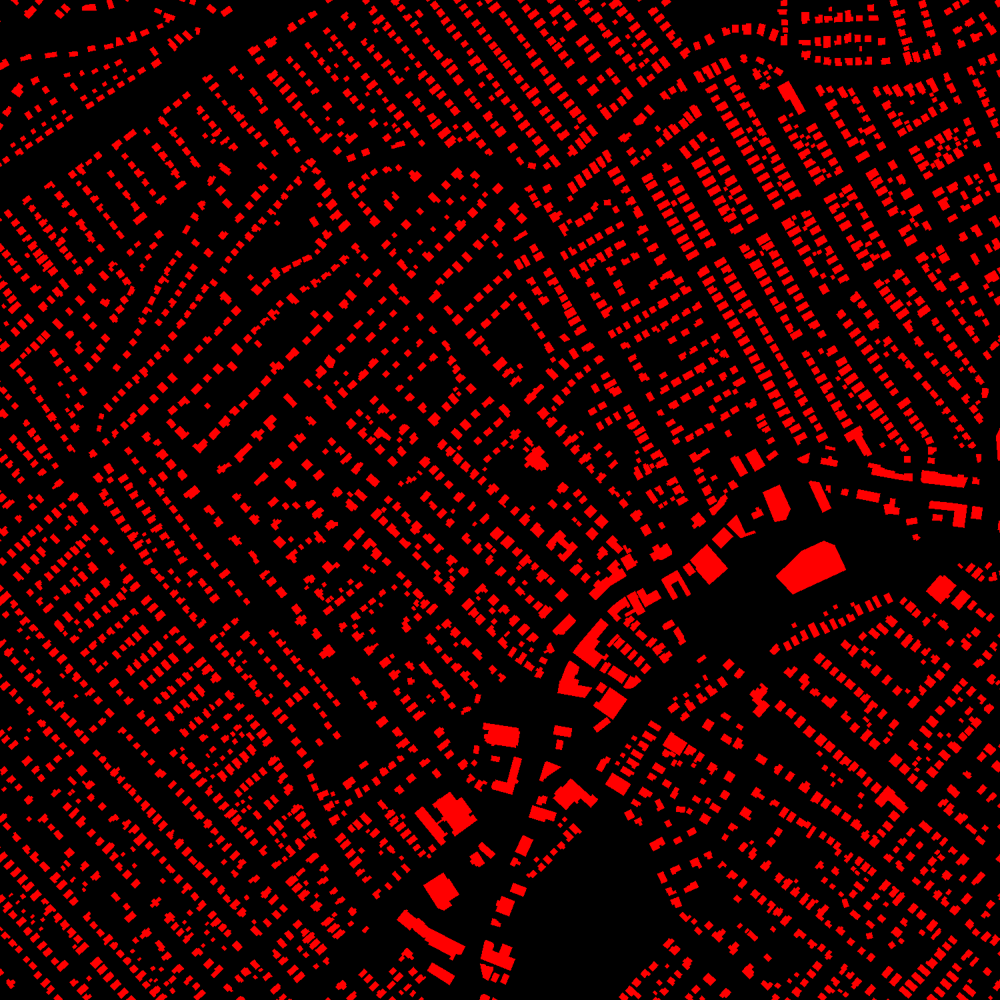

In [60]:
PIL.Image.open('dataset/Labels/test/22828930_15.tif').resize((1000,1000))